In [1]:
import numpy as np

# 3장 딥러닝 기초

## 3.4 전결합층 구현

### 3.4.1 공통 클래스 구현

In [4]:
# BaseLayer 클래스를 update 메소드로 구현
# 최적화 알고리즘을 구현하기 위해 확률적 경사 하강법(SGD)을 구현

In [2]:
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [3]:
# self.이 붙어있는 변수는 다른 메소드나 외부와 공유하는 변수
# 아다그라드나 아담 등의 최적화 알고리즘을 구현할 때 위 BaseLayer 클래스를 변경해야함.

### 3.4.2 은닉층 구현

In [5]:
# 초기화를 위해 __init__ 메소드, 순전파를 위한 forward 메소드, 역전파를 위한 backward 메소드

In [7]:
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#### __init__ 메소드

In [8]:
# n_upper는 앞 층의 뉴런 수, n은 해당 층의 뉴런 수
# 가중치 self.w의 초깃값은 평균이 0이고 표준편타가 루트(2/m)인 He초깃값 사용
# m은 앞 층의 뉴런 수
# He 초깃값은 활성화 함수가 ReLU일 때, 여러 층을 거쳐도 값에 편향이 생기기 어렵다고 알려짐

#### forward 메소드

In [9]:
# 활성화 함수로 ReLU함수 사용
# ReLU는 forward 메소드 안에 where 함수를 사용해 구현

#### backward 메소드

In [10]:
# delta 계산
# 우변은 출력 기울기와 활성화 함수를 편미분한 것(편도함수)의 곱으로, 인수인 grad_y가 출력 기울기
# ReLU의 편도함수 아래 식과 같음
# np.where(self.u <= 0, 0, 1)
# grad_y * np.where(self.u <= 0, 0, 1) 의 결과값으로 delta 구하고, 이 값으로 각 기울기 계산

### 3.4.3 출력층 구현

In [11]:
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        slef.grad_x = np.dot(delta, self.w.T)

#### __init__ 메소드

In [12]:
# 가중치 self.w의 초깃값에 표준편차 값이 (시그마 = 루트(1/m))인 자비에르 초기화 기반의 초깃값을 사용
# m은 앞 층의 뉴런 수
# 자비에르 초기화 기반의 초깃값은 활성화함수가 좌우대칭일 경우 값의 편차가 커지는 것을 방지해줌

#### forward 메소드

In [13]:
# 소프트맥스 함수를 활성화 함수로 이용
# 소프트맥스 함수는 함수의 출력값 y는 반드시 0보다 크며 층의 모든 뉴런에서 총합을 구하면 값이 1이므로 확률을 표현하는데 사용됨
# sum 함수를 이용해 소프트맥스 함수를 구현하는데, axis=1 로 지정하고 샘플마다 총합을 구하고,
# keepdims = True로 지정해 배열의 차원을 유지해줌

#### backward 메소드

In [14]:
# 출력 기울기와 활성화 함수의 편도함수 곱을 이용해 delta 계산
# 예제 코드는 다수의 클래스를 분류하는 문제이므로 교차 엔트로피 오차를 오차함수로 사용

## 3.5 단순한 딥러닝 구현

### 3.5.1 손글씨 숫자 이미지 데이터 확인

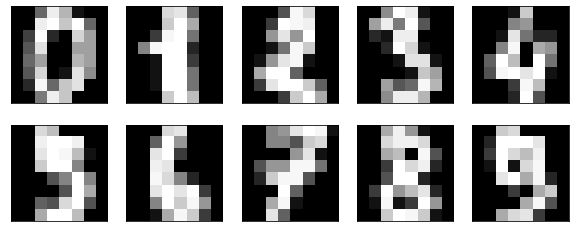

데이터 형태: (1797, 64)
레이블: [0 1 2 3 4 5 6 7 8 9]


In [17]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10  # 출력할 이미지 개수
plt.figure(figsize=(10,4))
for i in range(n_img):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("데이터 형태:", digits_data.data.shape)
print("레이블:", digits_data.target[:n_img])

### 3.5.2 데이터 전처리

In [18]:
# 입력과 정답 데이터를 표준화하고 원핫 인코딩으로 변경

In [28]:
from sklearn.model_selection import train_test_split

# input_data = np.asarray(digits_data.data)
# input_data = (input_data - np.average(input_data)) / np.std(input_data)

# correct = np.asarray(digits_data.target)
# correct_data = np.zeros((len(correct), n_out))
# for i in range(len(correct)):
#    correct_data[i, correct[i]] = 1
    
# x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

### 3.5.3 순전파와 역전파

In [27]:
# -- 각 층의 초기화 --
# layers = [MiddleLayer(img_size*img_size, n_mid),
#         MiddleLayer(n_mid, n_mid),
#         OutputLayer(n_mid, n_out)]

# -- 순전파 --
# def forward_propagation(x):
#    for layer in layers:
#        layer.forward(x)
#        x = layer.y
#    return x

# -- 역전파 --
# def backwardpropagation(t):
#    grad_y = t
#    for layer in reversed(layers):
#        layer.backward(grad_y)
#        grad_y = layer.grad_x
#    return grad_y

# -- 파라미터 갱신 --
# def update_params():
#    for layer in layers:
#        layer.update(eta)

### 3.5.4 미니 배치 구현

In [26]:
# n_batch = len(x_train) // batch_size  # 1에포크당 배치 개수
# for i in range(epochs):
    
    # -- 학습 --
#    index_random = np.arange(len(x_train))
#    np.random.shuffle(index_random)   # 인덱스를 랜덤으로 섞기
#    for j in range(n_batch):
        
        # 미니 배치 구성
#        mb_index = index_random[j*batch_size : (j+1)*batch_size]
#        x_mb = x_train[mb_index, :]
#        t_mb = t_train[mb_index, :]
        
        # 순전파와 역전파
#        forward_propagation(x_mb)
#        backwardpropagation(t_mb)
        
        # 파라미터 갱신
#        update_params()

## 3.6 손글씨 숫자 이미지 인식의 전체 코드

Epoch:1/51 Error_train: 2.623523639024449 Error_test: 2.5749005129959963
Epoch:1/51 Error_train: 2.545802253742348 Error_test: 2.505280285333727
Epoch:1/51 Error_train: 2.4936987455976634 Error_test: 2.4572610524979175
Epoch:1/51 Error_train: 2.444112443085972 Error_test: 2.4084585332186643
Epoch:1/51 Error_train: 2.4003413282108967 Error_test: 2.368945242291979
Epoch:1/51 Error_train: 2.3650208044385397 Error_test: 2.338509733864131
Epoch:1/51 Error_train: 2.338853894037925 Error_test: 2.3161570344096636
Epoch:1/51 Error_train: 2.3177975698749713 Error_test: 2.296200749230702
Epoch:1/51 Error_train: 2.2958396054157046 Error_test: 2.2790446867098573
Epoch:1/51 Error_train: 2.272310793162591 Error_test: 2.257469124234819
Epoch:1/51 Error_train: 2.2556204807572726 Error_test: 2.244544908117176
Epoch:1/51 Error_train: 2.2436857198665128 Error_test: 2.2328007017565925
Epoch:1/51 Error_train: 2.224153607811394 Error_test: 2.2151599883283324
Epoch:1/51 Error_train: 2.215732816033696 Error_te

Epoch:16/51 Error_train: 0.15613261501339926 Error_test: 0.24445509746713606
Epoch:16/51 Error_train: 0.14586876743923916 Error_test: 0.23389775913471383
Epoch:16/51 Error_train: 0.1447437413921645 Error_test: 0.23368492773270627
Epoch:16/51 Error_train: 0.14235945788572807 Error_test: 0.23544350976790646
Epoch:16/51 Error_train: 0.14511630376859194 Error_test: 0.23222024589046086
Epoch:16/51 Error_train: 0.14445932506435374 Error_test: 0.23457458057689
Epoch:16/51 Error_train: 0.1429876855872739 Error_test: 0.23729720131236193
Epoch:16/51 Error_train: 0.1439256472403187 Error_test: 0.2374173763098726
Epoch:16/51 Error_train: 0.14196170556206322 Error_test: 0.23516782508313822
Epoch:16/51 Error_train: 0.14234933252173343 Error_test: 0.23294561781280307
Epoch:16/51 Error_train: 0.142469527452563 Error_test: 0.23482575739308464
Epoch:16/51 Error_train: 0.1432177477788159 Error_test: 0.240054102852033
Epoch:16/51 Error_train: 0.14114254963381095 Error_test: 0.23451000568858998
Epoch:16/51

Epoch:31/51 Error_train: 0.06972852280353753 Error_test: 0.17445618181974717
Epoch:31/51 Error_train: 0.0677326640719915 Error_test: 0.1709008155359571
Epoch:31/51 Error_train: 0.06908001949079336 Error_test: 0.1736725811744385
Epoch:31/51 Error_train: 0.06902091063812946 Error_test: 0.1730806318249149
Epoch:31/51 Error_train: 0.06905746732941213 Error_test: 0.17408690047524034
Epoch:31/51 Error_train: 0.06830535226124183 Error_test: 0.16575852724299592
Epoch:31/51 Error_train: 0.06812948958815919 Error_test: 0.166976072354488
Epoch:31/51 Error_train: 0.0695911396800247 Error_test: 0.1683210894614595
Epoch:31/51 Error_train: 0.06872078613757017 Error_test: 0.16653203355813712
Epoch:31/51 Error_train: 0.06850510477511071 Error_test: 0.16588417207229847
Epoch:31/51 Error_train: 0.06790233726084938 Error_test: 0.16421937320632807
Epoch:31/51 Error_train: 0.06641621329420849 Error_test: 0.16491375285752352
Epoch:31/51 Error_train: 0.06632450712931935 Error_test: 0.16739551512825887
Epoch:3

Epoch:46/51 Error_train: 0.043580916459584396 Error_test: 0.15885524040175103
Epoch:46/51 Error_train: 0.04338678082616609 Error_test: 0.1670328978885142
Epoch:46/51 Error_train: 0.04350366860379178 Error_test: 0.16844318181497114
Epoch:46/51 Error_train: 0.04242684071264099 Error_test: 0.16631621856266657
Epoch:46/51 Error_train: 0.04196467082654085 Error_test: 0.16480253279260998
Epoch:46/51 Error_train: 0.04025661035793676 Error_test: 0.1578603119541279
Epoch:46/51 Error_train: 0.04046204731456474 Error_test: 0.15315441607385474
Epoch:46/51 Error_train: 0.042084069624420656 Error_test: 0.1604112228578482
Epoch:46/51 Error_train: 0.04047452661954239 Error_test: 0.1572943527301521
Epoch:46/51 Error_train: 0.039897290380602184 Error_test: 0.15503727334851292
Epoch:46/51 Error_train: 0.04000945502971825 Error_test: 0.1543292926638313
Epoch:46/51 Error_train: 0.039698732530092186 Error_test: 0.15261586621670795
Epoch:46/51 Error_train: 0.039880705715223466 Error_test: 0.1532081694622039


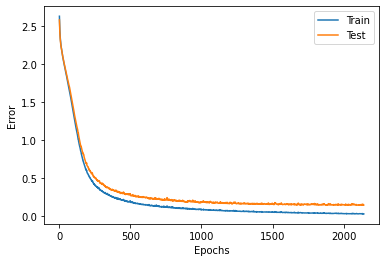

Acc_train: 99.4060876020787% Acc_test: 96.44444444444444%


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

img_size = 8    # 이미지 크기와 폭
n_mid = 16      # 은닉층 뉴런 수
n_out = 10
eta = 0.001     # 학습률
epochs = 51
batch_size = 32
interval = 5    # 경과 시간 표시 간격

digits_data = datasets.load_digits()

input_data = np.asarray(digits_data.data)
input_data = (input_data - np.average(input_data)) / np.std(input_data)

correct = np.asarray(digits_data.target)
correct_data = np.zeros((len(correct), n_out))
for i in range(len(correct)):
    correct_data[i, correct[i]] = 1   # 원핫 인코딩
    
# 데이터 분할
x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

# 전결합층의 부모 클래스
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# 은닉층
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)   # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLU 미분
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# 출력층
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)    #자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# 각 층의 초기화
layers = [MiddleLayer(img_size*img_size, n_mid),
         MiddleLayer(n_mid, n_mid),
         OutputLayer(n_mid, n_out)]

# 순전파
def forward_propagation(x):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

# 역전파
def backwardpropagation(t):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

# 파라미터 갱신
def update_params():
    for layer in layers:
        layer.update(eta)
        
# 오차 측정
def get_error(x,t):
    y = forward_propagation(x)
    return -np.sum(t*np.log(y+1e-7)) / len(y)   # 교차 엔트로피 오차

# 정답률 측정
def get_accuracy(x, t):
    y = forward_propagation(x)
    count = np.sum(np.argmax(y, axis=1) == np.argmax(t, axis=1))
    return count / len(y)

# 오차 기록
error_record_train = []
error_record_test = []

n_batch = len(x_train) // batch_size   # 1에포크당 배치 개수
for i in range(epochs):
    
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        
        # 미니 배치 생성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]
        
        # 순전파와 역전파
        forward_propagation(x_mb)
        backwardpropagation(t_mb)
        
        # 파라미터 갱신
        update_params()
        
        # 오차 측정 및 기록
        error_train = get_error(x_train, t_train)
        error_record_train.append(error_train)
        error_test = get_error(x_test, t_test)
        error_record_test.append(error_test)
        
        # 경과 표시
        if i%interval == 0 :
            print("Epoch:" + str(i+1) + "/" + str(epochs), 
                  "Error_train: " + str(error_train),
                  "Error_test: " + str(error_test))
            
# 오차 추이를 그래프로 표시
plt.plot(range(1, len(error_record_train)+1), error_record_train, label="Train")
plt.plot(range(1, len(error_record_test)+1), error_record_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# 정답률 측정
acc_train = get_accuracy(x_train, t_train)
acc_test = get_accuracy(x_test, t_test)
print("Acc_train: "+str(acc_train*100)+"%",
     "Acc_test: "+str(acc_test*100)+"%")
